# Binance Client Test Notebook

In [1]:
import sys
import os
from datetime import datetime, timedelta
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Add the src directory to the Python path
sys.path.append(os.path.abspath(os.path.join('..', 'src')))

from clients.binance_client import BinanceClient

/Users/cleme/stablecoins_optimizer/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


## Initialize Binance Client

In [2]:
# Initialize client
client = BinanceClient(api_key=os.getenv('binance_api_key'), secret=os.getenv('binance_api_secret'))

## Fetch Current Funding Rates

In [3]:
symbols = ['BTC/USDT:USDT', 
           'ETH/USDT:USDT', 
           'SOL/USDT:USDT', 
           'XRP/USDT:USDT', 
           'BNB/USDT:USDT', 
           'DOGE/USDT:USDT', 
           '1000PEPE/USDT:USDT', 
           'TON/USDT:USDT', 
           'AVAX/USDT:USDT', 
           'WIF/USDT:USDT', 
           'MATIC/USDT:USDT', 
           'AAVE/USDT:USDT', 
           'LINK/USDT:USDT', 
           'SUI/USDT:USDT', 
           'ADA/USDT:USDT']
current_rates = client.get_current_funding_rates(symbols)
print("Current Funding Rates:")
display(current_rates)

Current Funding Rates:


,Symbol,Mark Price,Index Price,Funding Rate,Timestamp,Datetime,Funding Timestamp,Funding Datetime,Annualized Funding Rate
0,BTC/USDT:USDT,61583.922050,61614.122979,-4.268000e-05,1724428588000,2024-08-23T15:56:28.000Z,1724428800000,2024-08-23T16:00:00.000Z,-4.673460
1,ETH/USDT:USDT,2673.819667,2675.329091,6.300000e-07,1724428590000,2024-08-23T15:56:30.000Z,1724428800000,2024-08-23T16:00:00.000Z,0.068985
2,SOL/USDT:USDT,144.481000,144.545018,-4.658000e-05,1724428591000,2024-08-23T15:56:31.000Z,1724428800000,2024-08-23T16:00:00.000Z,-5.100510
3,XRP/USDT:USDT,0.599736,0.599895,3.741000e-05,1724428592000,2024-08-23T15:56:32.000Z,1724428800000,2024-08-23T16:00:00.000Z,4.096395
4,BNB/USDT:USDT,580.977303,581.383622,-2.524400e-04,1724428592000,2024-08-23T15:56:32.000Z,1724428800000,2024-08-23T16:00:00.000Z,-27.642180
5,DOGE/USDT:USDT,0.110006,0.110044,6.125000e-05,1724428593000,2024-08-23T15:56:33.000Z,1724428800000,2024-08-23T16:00:00.000Z,6.706875
6,1000PEPE/USDT:USDT,0.008230,0.008231,9.440000e-06,1724428593000,2024-08-23T15:56:33.000Z,1724428800000,2024-08-23T16:00:00.000Z,1.033680
7,TON/USDT:USDT,6.590200,6.591917,2.184000e-05,1724428593000,2024-08-23T15:56:33.000Z,1724428800000,2024-08-23T16:00:00.000Z,2.391480
8,AVAX/USDT:USDT,26.165000,26.168810,1.118000e-05,1724428595000,2024-08-23T15:56:35.000Z,1724428800000,2024-08-23T16:00:00.000Z,1.224210
9,WIF/USDT:USDT,1.636400,1.637353,-1.072700e-04,1724428595000,2024-08-23T15:56:35.000Z,1724428800000,2024-08-23T16:00:00.000Z,-11.746065


## Visualize Current Funding Rates

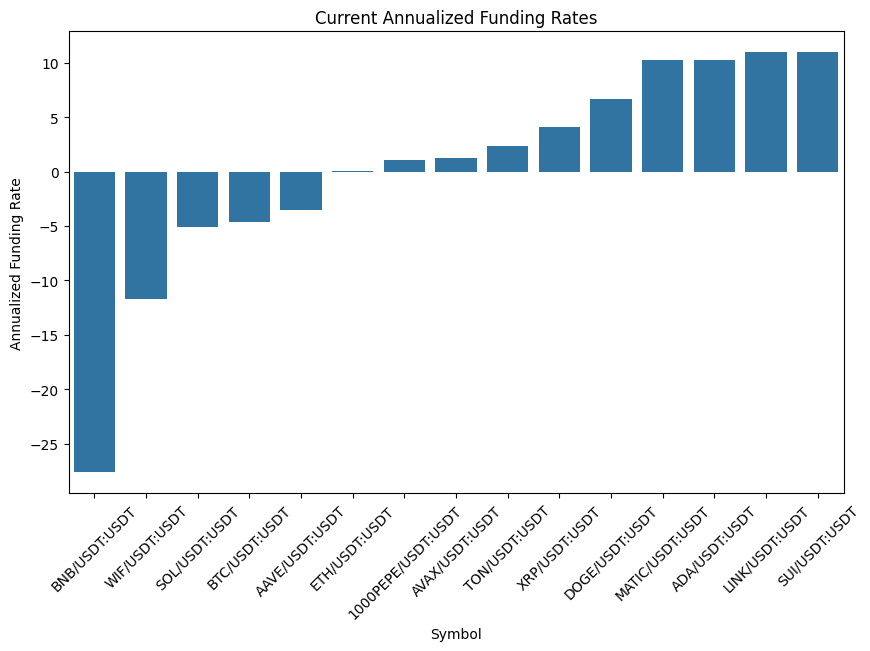

In [4]:
plt.figure(figsize=(10, 6))
current_rates_sorted = current_rates.sort_values(by='Annualized Funding Rate')
sns.barplot(x='Symbol', y='Annualized Funding Rate', data=current_rates_sorted)
plt.title('Current Annualized Funding Rates')
plt.xticks(rotation=45)
plt.show()

## Fetch current positions and prices on Future and Spot

In [9]:
# Fetch spot position
future_symbol = 'LINK/USDT:USDT'
spot_symbol = 'LINK/USDT'
spot_position = client.fetch_spot_position(spot_symbol)
print(f"Spot position for {spot_symbol}: {spot_position}")

# Fetch futures position
futures_position = client.fetch_futures_position(future_symbol)
print(f"Futures position for {future_symbol}:")
display(futures_position)

# Fetch real-time prices
real_time_prices = client.fetch_real_time_prices(spot_symbol)
print(f"Real-time prices for {spot_symbol}:")
display(real_time_prices)

Spot position for LINK/USDT: 16.6833
Futures position for LINK/USDT:USDT:


{'info': {'symbol': 'LINKUSDT',
  'positionSide': 'BOTH',
  'positionAmt': '-16.54',
  'entryPrice': '11.68',
  'breakEvenPrice': '11.67416',
  'markPrice': '11.67219493',
  'unRealizedProfit': '0.12909585',
  'liquidationPrice': '17.43498507',
  'isolatedMargin': '96.75842225',
  'notional': '-193.05810414',
  'marginAsset': 'USDT',
  'isolatedWallet': '96.62932640',
  'initialMargin': '96.52905207',
  'maintMargin': '0.96529052',
  'positionInitialMargin': '96.52905207',
  'openOrderInitialMargin': '0',
  'adl': '3',
  'bidNotional': '0',
  'askNotional': '0',
  'updateTime': '1724429571315'},
 'id': None,
 'symbol': 'LINK/USDT:USDT',
 'contracts': 16.54,
 'contractSize': 1.0,
 'unrealizedPnl': 0.12909585,
 'leverage': None,
 'liquidationPrice': 17.43498507,
 'collateral': 96.75842225,
 'notional': 193.05810414,
 'markPrice': 11.67219493,
 'entryPrice': 11.68,
 'timestamp': 1724429571315,
 'initialMargin': 96.52905207,
 'initialMarginPercentage': 0.5,
 'maintenanceMargin': 0.96529052

Real-time prices for LINK/USDT:


{'spot': 11.68, 'future': 11.673}

## Get OHLCV data

In [7]:
symbol = 'BTC/USDT:USDT'
start_time = datetime.now() - timedelta(days=30)  # Last 30 days
ohlcv_data = client.get_ohlcv(symbol, timeframe='1d', since=start_time, limit=30)
display(ohlcv_data)

,timestamp,open,high,low,close,volume,datetime
0,1721865600000,65350.7,66144.0,63456.7,65773.0,319685.441,2024-07-25
1,1721952000000,65773.0,68200.0,65688.2,67882.5,235384.526,2024-07-26
2,1722038400000,67882.5,69381.7,66624.5,67873.8,330982.647,2024-07-27
3,1722124800000,67873.7,68300.0,67037.0,68215.5,116913.935,2024-07-28
4,1722211200000,68215.5,70081.0,66365.8,66750.0,372537.818,2024-07-29
5,1722297600000,66750.1,66966.6,65254.5,66159.3,246551.044,2024-07-30
6,1722384000000,66159.3,66826.3,64500.4,64601.8,246389.446,2024-07-31
7,1722470400000,64601.8,65650.0,62271.2,65328.9,372654.590,2024-08-01
8,1722556800000,65329.0,65577.0,61200.2,61483.7,421628.420,2024-08-02
9,1722643200000,61483.7,62166.0,59800.0,60684.6,290469.956,2024-08-03


## Fetch Historical Funding Rates

In [5]:
start_time = datetime.now() - timedelta(days=30)
start_time.timestamp() * 1000

1721836600734.691

In [6]:
# Fetch Historical Funding Rates
symbol = 'BTC/USDT:USDT'
# Define start_time as a datetime object
start_time = datetime.now() - timedelta(days=30)
# Define end_time as the current datetime
end_time = datetime.now()

# Pass both datetime objects to the method
historical_rates = client.get_historical_funding_rates(symbol, start_time, end_time)
print("Historical Funding Rates:")
display(historical_rates.head())

ERROR:clients.binance_client:Error fetching historical funding rates for BTC/USDT:USDT: binance {"status":"ERROR","type":"VALID","code":"000002","errorData":{"limit":"Failed to convert property value of type 'java.lang.String' to required type 'java.lang.Integer' for property 'limit'; nested exception is java.lang.NumberFormatException: For input string: \"1724428600752\""},"data":null,"subData":null,"params":null}


Historical Funding Rates:


""


## Visualize Historical Funding Rates

In [7]:
plt.figure(figsize=(12, 6))
plt.plot(historical_rates['datetime'], historical_rates['annualized_rate'])
plt.title(f'Historical Annualized Funding Rates for {symbol}')
plt.xlabel('Date')
plt.ylabel('Annualized Funding Rate (%)')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

KeyError: 'datetime'

<Figure size 1200x600 with 0 Axes>

## Fetch OHLCV Data

In [ ]:
ohlcv_data = client.get_ohlcv(symbol, '1d', since=start_time)
print("OHLCV Data:")
display(ohlcv_data.head())

OHLCV Data:


,timestamp,open,high,low,close,volume,datetime
0,1721779200000,65916.3,67087.3,65040.5,65350.8,215079.421,2024-07-24
1,1721865600000,65350.7,66144.0,63456.7,65773.0,319685.441,2024-07-25
2,1721952000000,65773.0,68200.0,65688.2,67882.5,235384.526,2024-07-26
3,1722038400000,67882.5,69381.7,66624.5,67873.8,330982.647,2024-07-27
4,1722124800000,67873.7,68300.0,67037.0,68215.5,116913.935,2024-07-28


## Visualize OHLCV Data

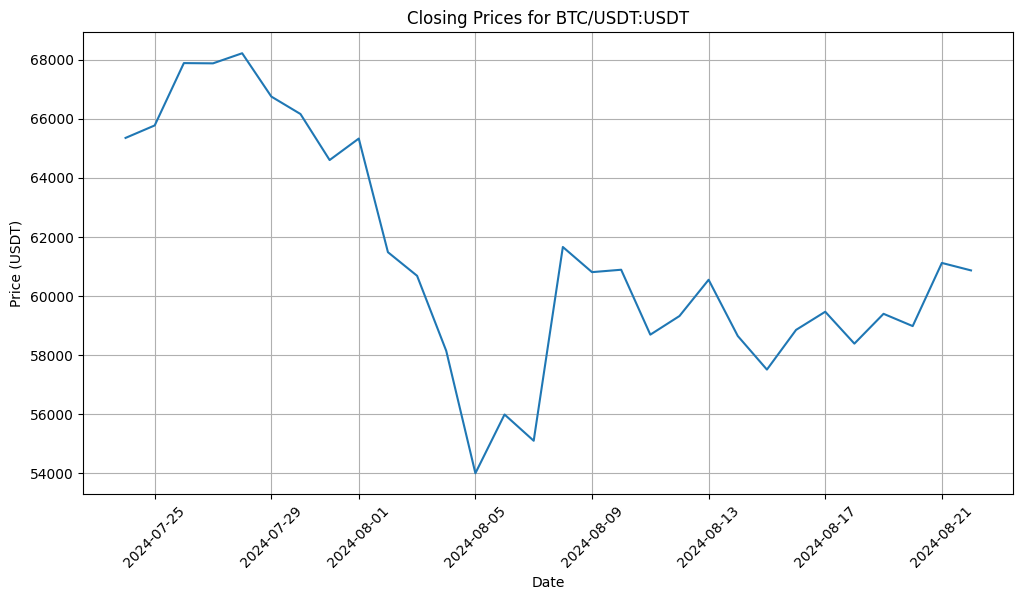

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(ohlcv_data['datetime'], ohlcv_data['close'])
plt.title(f'Closing Prices for {symbol}')
plt.xlabel('Date')
plt.ylabel('Price (USDT)')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

## Analyze Correlation Between Price and Funding Rate

In [ ]:
# Merge OHLCV and funding rate data
merged_data = pd.merge(ohlcv_data, historical_rates, left_on='datetime', right_on='datetime', how='inner')

# Calculate correlation
correlation = merged_data['close'].corr(merged_data['annualized_rate'])
print(f"Correlation between price and funding rate: {correlation:.2f}")

# Visualize
plt.figure(figsize=(10, 6))
plt.scatter(merged_data['close'], merged_data['annualized_rate'])
plt.title(f'Price vs Funding Rate for {symbol}')
plt.xlabel('Price (USDT)')
plt.ylabel('Annualized Funding Rate (%)')
plt.grid(True)
plt.show()

KeyError: 'datetime'